# Enfermedad en la sangre
## Nicolás Ariel Bustos Gonzalez

### En este desafío utilizaremos una base de datos recolectada en un laboratorio de donación de sangre, en la que contamos con información de diferentes mediciones incluido el sexo del donador y un indicador de donador sospechoso. Las variables regresoras son:
### 1. X (Patient ID/No.): Número o identificación única asociada a cada paciente en la base de datos.
### 2. Category (diagnosis): Categoría que indica el diagnóstico relacionado con la hepatitis C para cada paciente.
### 3. Age (in years): Edad del paciente en años al momento de la detección o registro en la base de datos.
### 4. Sex (f,m): Género del paciente, indicado por "f" para femenino y "m" para masculino.
### 5. ALB: Albúmina, una proteína producida por el hígado. Los niveles de albúmina pueden indicar la función hepática.
### 6. ALP: Fosfatasa alcalina, una enzima que puede estar relacionada con la función hepática y otros procesos.
### 7. ALT: Alanina aminotransferasa, una enzima que puede indicar daño hepático.
### 8. AST: Aspartato aminotransferasa, una enzima que también puede indicar daño hepático.
### 9. BIL: Bilirrubina, un pigmento amarillo que puede aumentar en casos de problemas hepáticos.
### 10. CHE: Colinesterasa, una enzima que puede estar asociada con la función hepática y otros procesos.
### 11. CHOL: Colesterol, un lípido que puede estar relacionado con la salud del hígado.
### 12. CREA: Creatinina, un producto de desecho que se filtra a través de los riñones.
### 13. GGT: Gamma-glutamil transferasa, una enzima que puede estar relacionada con la función hepática.
### 14. PROT: Proteínas totales, que pueden incluir varias proteínas, como albúmina y globulinas.

### La variable objetivo es Category, y almacena las siguientes categorías: ‘0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis’ Aplicando los conceptos y herramientas aprendidas hasta ahora, deberás realizar las siguientes tareas:
## 1. Importa las librerías necesarias para entrenar modelos de regresión logística con validación cruzada y Extreme Gradient Boosting, carga los datos y prepáralos. Para ello:
### a. elimina la columna ‘Unnamed: 0’.
### b. codifica la variable objetivo Category en dos categorías: una para Category=’0=Blood Donor’, a la que debes asociar valor 0, y un 1 para los demás valores. Asigna estos valores en una nueva columna llamada target.
### c. codifica en otra columna, con nombre suspect, con valor 1 cuando Category=’0s=suspect Blood Donor’, y aigna 0 en caso contrario. Elimina finalmente la columna Category.
### d. Revisa si la base de datos contiene valores ausentes. En caso que sea así, aplica los siguientes criterios:
#### i. si el porcentaje de valores ausentes para alguna variable es menor a 1%, entonces elimina las filas que contengan estos valores ausentes
#### ii. si el porcentaje de valores ausentes es mayor, entonces reemplaza estos por el promedio según la clase a la que pertenezca el valor ausente.
### e. Realiza un análisis descriptivo para cada variable regresora, usando gráficos para representar distribuciones y boxplot para revisar posibles outliers. Construye un heatmap que muestre las correlaciones entre las variables regresoras y describe.
### f. Transforma las variables regresoras por medio de la estandarización. Muestra el antes y después de esta usando boxplots, y realiza una segmentación de la muestra en 33% para test y el resto para entrenamiento.

NA restantes por columna (top 10):
Age     0
Sex     0
ALB     0
ALP     0
ALT     0
AST     0
BIL     0
CHE     0
CHOL    0
CREA    0
dtype: int64


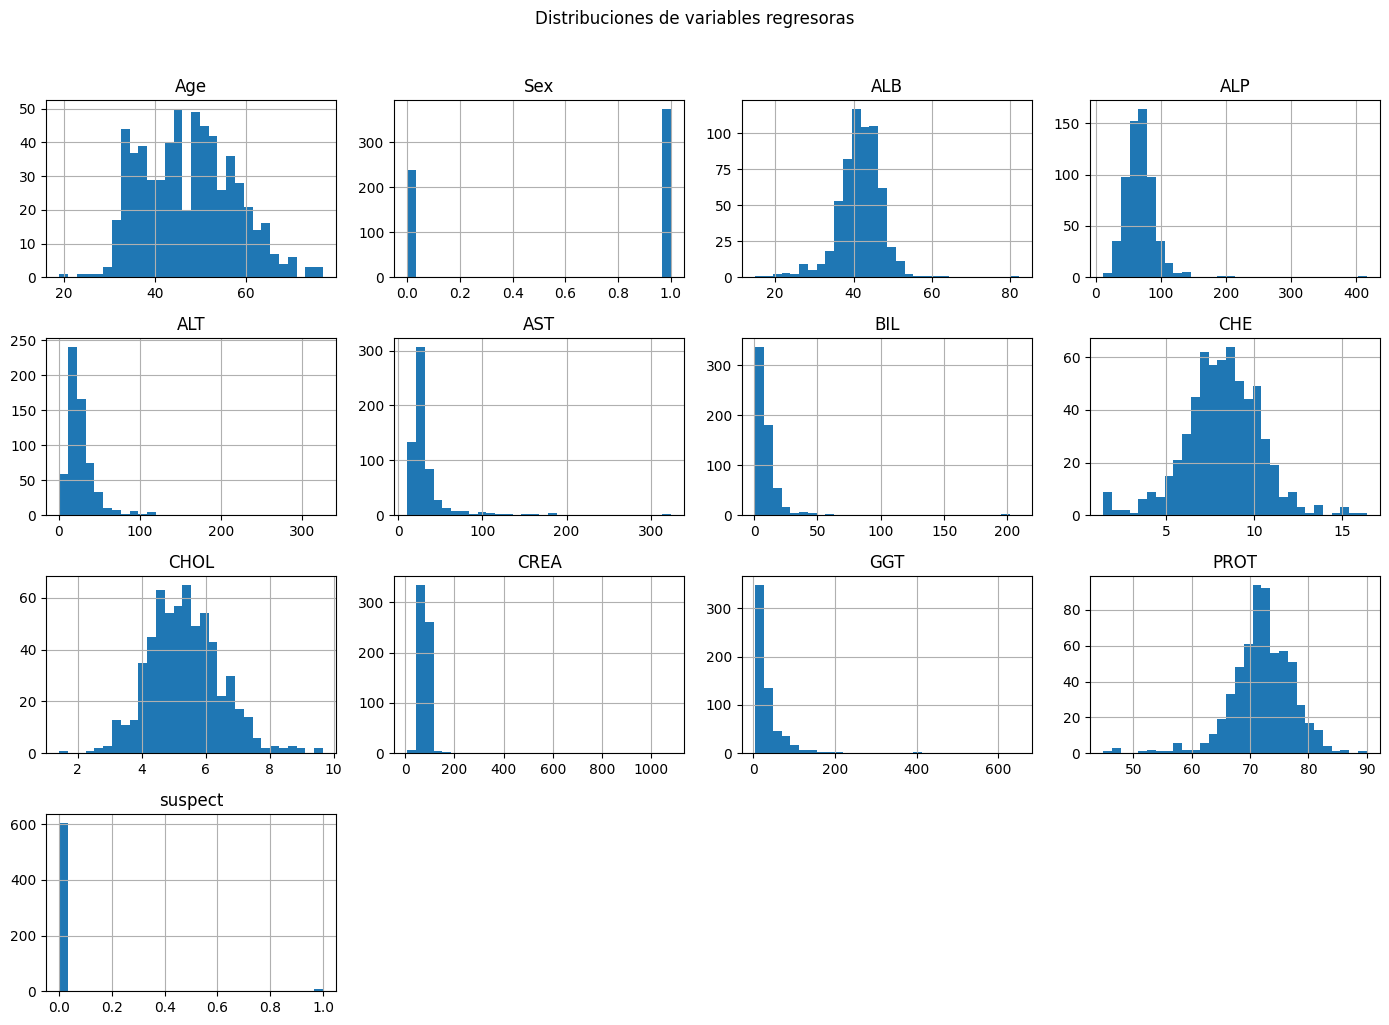

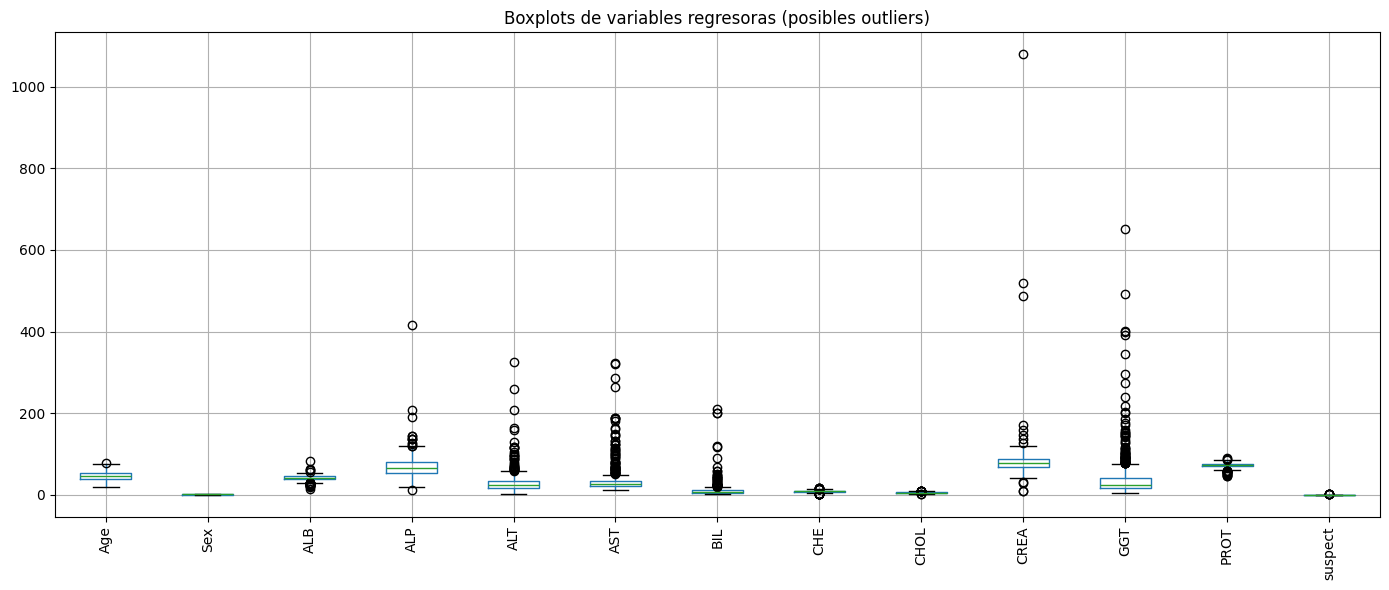

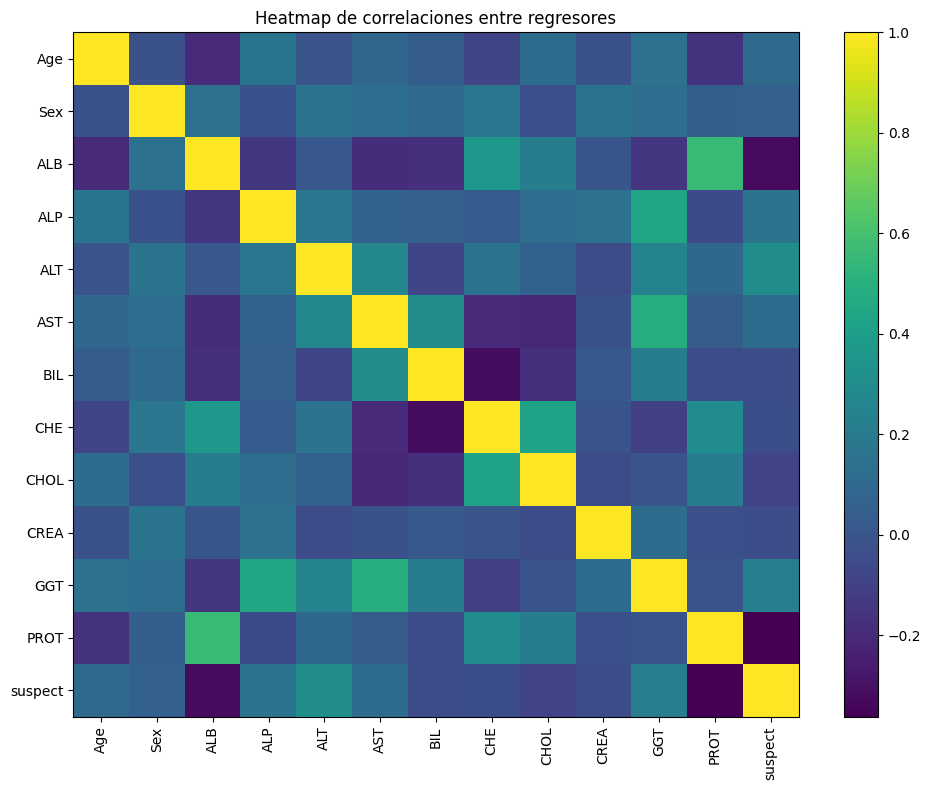


Top correlaciones (abs) entre variables:
ALB   PROT    0.560239
PROT  ALB     0.560239
GGT   AST     0.487421
AST   GGT     0.487421
GGT   ALP     0.443403
ALP   GGT     0.443403
CHE   CHOL    0.424361
CHOL  CHE     0.424361
CHE   ALB     0.363820
ALB   CHE     0.363820
dtype: float64


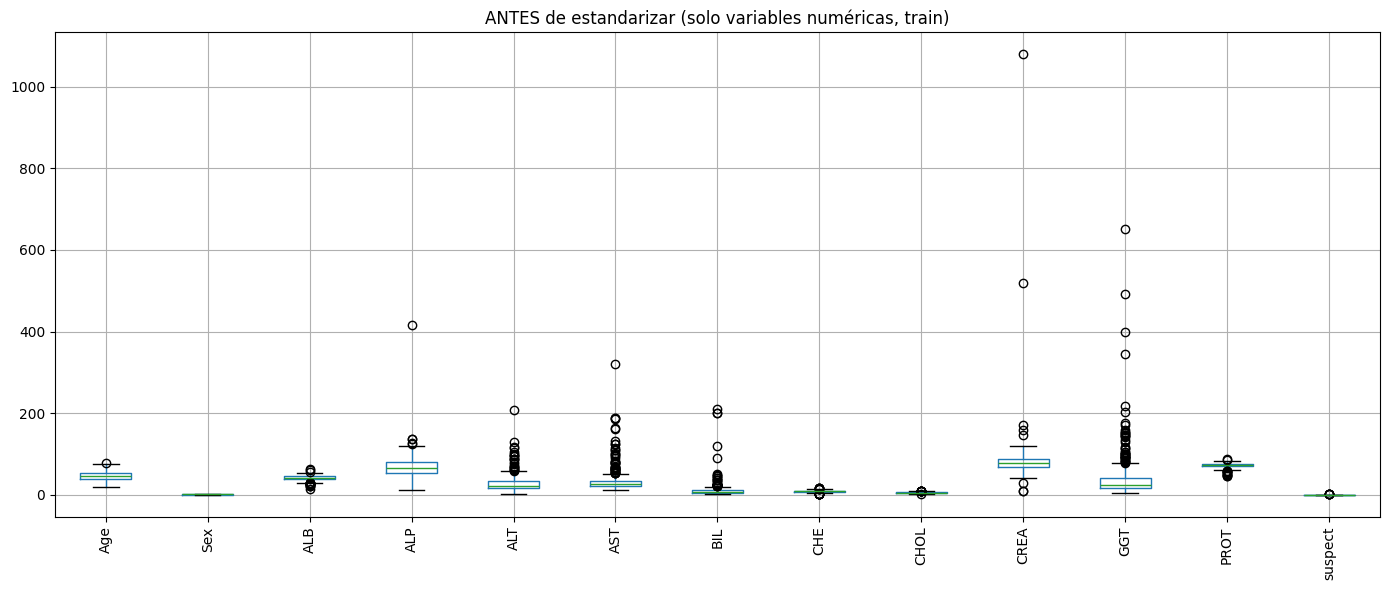

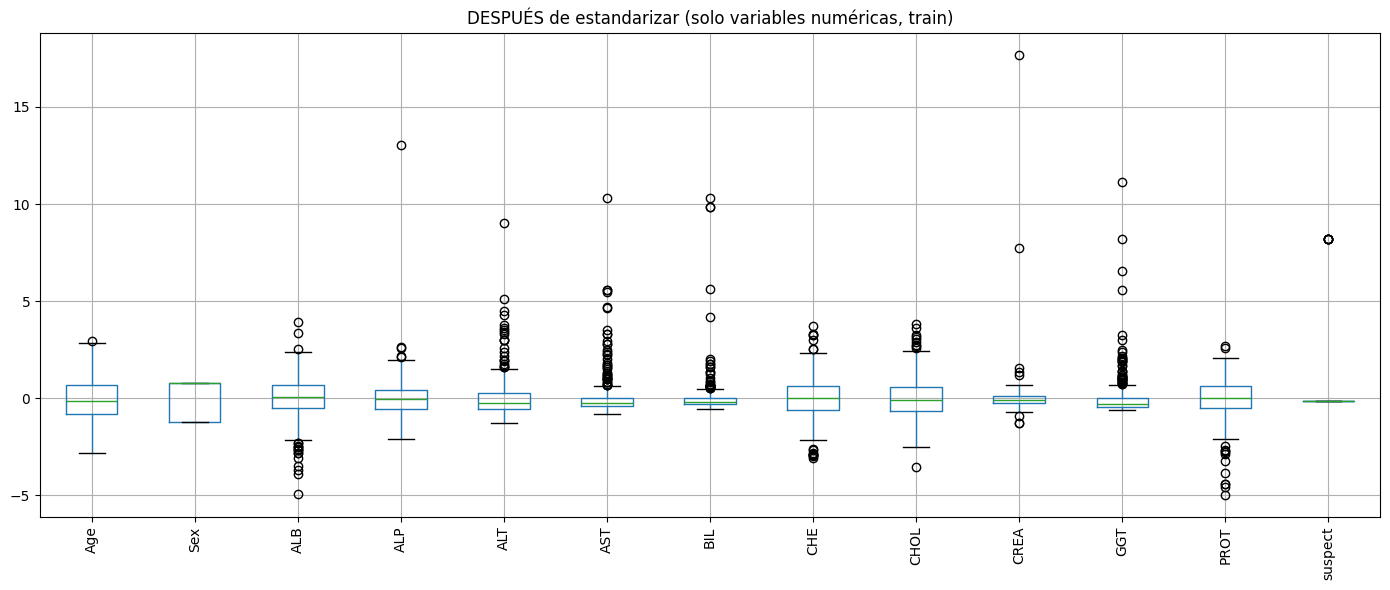


Shapes:
X_train: (410, 13) X_test: (202, 13)
y_train: (410,) y_test: (202,)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

df = pd.read_csv("hcvdat0.csv")

# Eliminar 'Unnamed: 0'
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Target: 0 si Blood Donor, 1 si no
df["target"] = (df["Category"] != "0=Blood Donor").astype(int)

# Suspect: 1 si suspect Blood Donor, si no 0. Luego borrar Category
df["suspect"] = (df["Category"] == "0s=suspect Blood Donor").astype(int)
df = df.drop(columns=["Category"])

# Codificar Sex (f/m -> 0/1).
if "Sex" in df.columns:
    df["Sex"] = df["Sex"].map({"f": 0, "m": 1})

# Valores ausentes:
# Si % NA < 1% -> eliminar filas con NA en esas columnas
#  Si % NA >= 1% -> imputar promedio según clase (target)
na_pct = df.isna().mean().sort_values(ascending=False)

low_na_cols  = na_pct[(na_pct > 0) & (na_pct < 0.01)].index.tolist()
high_na_cols = na_pct[na_pct >= 0.01].index.tolist()

# Drop filas (solo para columnas con NA < 1%)
if len(low_na_cols) > 0:
    df = df.dropna(subset=low_na_cols)

# Imputación por clase para columnas con NA >= 1%
for col in high_na_cols:
    df[col] = df[col].fillna(df.groupby("target")[col].transform("mean"))


print("NA restantes por columna (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))

# Separar regresores (X) y variable objetivo (y) para EDA
y = df["target"]
X = df.drop(columns=["target"])

# Hist / distribuciones
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

X[num_cols].hist(bins=30, figsize=(14, 10))
plt.suptitle("Distribuciones de variables regresoras", y=1.02)
plt.tight_layout()
plt.show()

# Boxplot para outliers
plt.figure(figsize=(14, 6))
X[num_cols].boxplot(rot=90)
plt.title("Boxplots de variables regresoras (posibles outliers)")
plt.tight_layout()
plt.show()

# Heatmap de correlaciones con matplotlib
corr = X[num_cols].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Heatmap de correlaciones entre regresores")
plt.tight_layout()
plt.show()

# Ver rápidamente los pares más correlacionados (absoluto)
corr_abs = corr.abs().unstack().sort_values(ascending=False)
corr_abs = corr_abs[corr_abs < 1.0] 
print("\nTop correlaciones (abs) entre variables:")
print(corr_abs.head(10))

# Split 33% test (recomendado: stratify para mantener proporciones)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

# Boxplot ANTES 
plt.figure(figsize=(14, 6))
X_train[num_cols].boxplot(rot=90)
plt.title("ANTES de estandarizar (solo variables numéricas, train)")
plt.tight_layout()
plt.show()

# Estandarizar (solo numéricas) para evitar tocar columnas no numéricas
scaler = StandardScaler()

X_train_sc = X_train.copy()
X_test_sc = X_test.copy()

X_train_sc[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_sc[num_cols] = scaler.transform(X_test[num_cols])

# Boxplot DESPUÉS 
plt.figure(figsize=(14, 6))
X_train_sc[num_cols].boxplot(rot=90)
plt.title("DESPUÉS de estandarizar (solo variables numéricas, train)")
plt.tight_layout()
plt.show()

print("\nShapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)


### El heatmap muestra correlaciones moderadas/altas entre enzimas hepáticas (p. ej., AST/ALT/ALP/GGT), lo que sugiere variables relacionadas con un mismo fenómeno fisiológico. Esto justifica el uso de regularización (Elastic Net) para estabilizar coeficientes y en XGBoost, permite capturar interacciones no lineales entre marcadores.

## 2. Desarrolla un modelo regresión logística con validación cruzada usando 5-fold, con regularización Elastic Net. Busca para los siguientes hiper parámetros:
### ● Cs: valores entre 0.01 y 5.0, con 200 valores lineales.
### ● l1_ratio: valores entre 0 y 1, con 200 valores lineales.
### Muestra los valores óptimos encontrados, y las métricas precisión, recall, f1-score y accuracy. Describe cuáles son las tres características con mayor incidencia en la predicción de sujeto o muestra con sangre con posible enfermedad.

In [ ]:
# Regresión Logística con Elastic Net + 5-Fold CV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)

# Grillas de hiperparámetros
Cs = np.linspace(0.01, 5.0, 200)
l1_ratios = np.linspace(0.0, 1.0, 200)


# Modelo
logit_en = LogisticRegressionCV(
    Cs=Cs,
    cv=5,
    penalty="elasticnet",
    solver="saga",        
    l1_ratios=l1_ratios,
    scoring="f1",        
    max_iter=5000,
    n_jobs=-1,
    refit=True
)

# Entrenamiento
logit_en.fit(X_train_sc, y_train)

# Mejores hiperparámetros encontrados
best_C = float(logit_en.C_[0])
best_l1_ratio = float(logit_en.l1_ratio_[0])

print("Mejor C encontrado:", best_C)
print("Mejor l1_ratio encontrado:", best_l1_ratio)

# Evaluación en test
y_pred = logit_en.predict(X_test_sc)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nMétricas en conjunto de test:")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)

print("\nReporte completo:")
print(classification_report(y_test, y_pred, digits=4))

# Coeficientes del modelo 
coef = logit_en.coef_.ravel()

# Creamos una serie con valores absolutos para medir "importancia"
feature_importance = pd.Series(
    np.abs(coef),
    index=X_train_sc.columns
).sort_values(ascending=False)

print("\nTop 10 variables más influyentes según |coef|:")
print(feature_importance.head(10))

print("\nTop 3 variables más influyentes:")
top3 = feature_importance.head(3)
print(top3)

# Gráfico
plt.figure(figsize=(8, 4))
feature_importance.head(10).sort_values().plot(kind="barh")
plt.title("Top 10 |coeficientes| - Logistic Regression Elastic Net")
plt.tight_layout()
plt.show()

### Se entrenó un modelo de regresión logística con regularización Elastic Net utilizando validación cruzada 5-fold, buscando los hiperparámetros C y l1_ratio en grillas de 200 valores cada una, optimizando el F1-score. El mejor modelo obtuvo un valor de C ≈ 1.87 y l1_ratio ≈ 0.216, lo que indica una combinación dominada por regularización L2 con una fracción menor de L1.

### En el conjunto de test, el modelo alcanzó un accuracy de 0.9455, precision de 0.9412, recall de 0.6154 y F1-score de 0.7442. Estos resultados indican un desempeño general alto, con especial énfasis en la precisión al identificar pacientes con posible enfermedad, aunque con una sensibilidad moderada, lo cual es consistente con el desbalance de clases presente en el dataset.

### Las tres variables con mayor incidencia en la predicción, según el valor absoluto de los coeficientes estandarizados, fueron GGT, ALP y suspect. Estas variables corresponden a marcadores clínicos directamente relacionados con el funcionamiento hepático, lo cual confirma que el modelo ha aprendido relaciones coherentes desde el punto de vista médico.

## 3. Implementa un modelo Extreme Gradient Boosting con búsqueda de hiper parámetros de grilla, con regularización para la combinación L1 y L2. Considera para esto:
### a. reg_lambda: valores entre 0.0 y 2.0, con 10 valores lineales.
### b. reg_alpha: valores entre 0 y 1, con 10 valores lineales.
### c. learning_rate: valores entre 0.1 a 10, con 20 valores lineales.

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Mejores hiperparámetros (GridSearch):
{'learning_rate': np.float64(1.142105263157895), 'reg_alpha': np.float64(0.1111111111111111), 'reg_lambda': np.float64(0.6666666666666666)}
Mejor F1 promedio en CV: 0.8770002546473133

Métricas en conjunto de test (XGBoost):
Accuracy : 0.9801980198019802
Precision: 0.9583333333333334
Recall   : 0.8846153846153846
F1-score : 0.92

Reporte completo:
              precision    recall  f1-score   support

           0     0.9831    0.9943    0.9887       176
           1     0.9583    0.8846    0.9200        26

    accuracy                         0.9802       202
   macro avg     0.9707    0.9395    0.9544       202
weighted avg     0.9800    0.9802    0.9799       202


Top 10 variables más importantes (XGBoost):
AST        0.441078
ALT        0.159037
ALP        0.117343
suspect    0.095725
CHOL       0.069589
GGT        0.067055
PROT       0.020852
BIL        0.015180
ALB        0.0

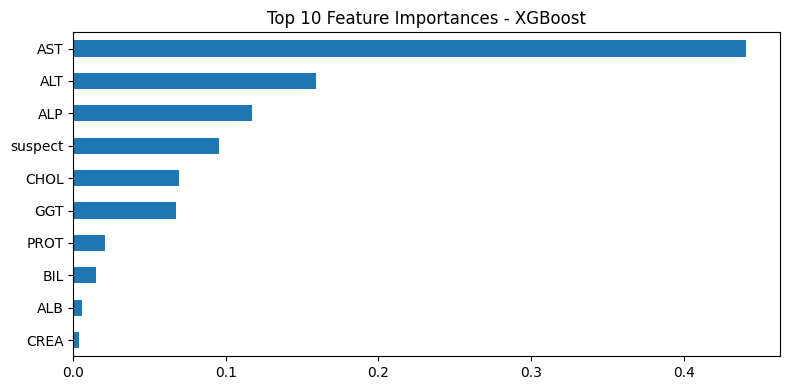

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from xgboost import XGBClassifier

# Verifica que existan las variables del ítem 1 ---
required_vars = ["X_train", "X_test", "y_train", "y_test"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(
        f"Faltan variables {missing}. Asegúrate de haber ejecutado el ítem 1 (split 33% test) "
        "y tener X_train, X_test, y_train, y_test (sin escalar)."
    )

# Modelo base 
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

# Grilla
param_grid = {
    "reg_lambda": np.linspace(0.0, 2.0, 10),
    "reg_alpha": np.linspace(0.0, 1.0, 10),
    "learning_rate": np.linspace(0.1, 10.0, 20)
}

# GridSearch con CV=5 
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

# Entrenamiento
grid.fit(X_train, y_train)

print("====================================")
print("Mejores hiperparámetros (GridSearch):")
print(grid.best_params_)
print("Mejor F1 promedio en CV:", grid.best_score_)
print("====================================")

# Evaluación en test
best_xgb = grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred_xgb)
prec = precision_score(y_test, y_pred_xgb)
rec = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

print("\nMétricas en conjunto de test (XGBoost):")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)

print("\nReporte completo:")
print(classification_report(y_test, y_pred_xgb, digits=4))

# Importancia de atributos
importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("\nTop 10 variables más importantes (XGBoost):")
print(importances.head(10))

# Gráfico top 10 importancias
plt.figure(figsize=(8, 4))
importances.head(10).sort_values().plot(kind="barh")
plt.title("Top 10 Feature Importances - XGBoost")
plt.tight_layout()
plt.show()

## 4. Muestra el nivel de importancia de los atributos, los valores óptimos de los hiper parámetros y las métricas precisión, recall, f1-score y accuracy. Compara los resultados de este modelo con el de regresión logística.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from IPython.display import display


# Variables esperadas
missing = []
for v in ["y_test"]:
    if v not in globals():
        missing.append(v)

# Para LogReg y_pred y logit_en y X_train_sc.columns
for v in ["y_pred", "logit_en", "X_train_sc"]:
    if v not in globals():
        missing.append(v)

# Para XGB: y_pred_xgb, best_xgb, X_train.columns
for v in ["y_pred_xgb", "best_xgb", "X_train"]:
    if v not in globals():
        missing.append(v)

if missing:
    raise NameError(
        f"Faltan variables para el ítem 4: {missing}\n"
        "Asegúrate de haber ejecutado el ítem 2 (LogReg ElasticNet) y el ítem 3 (XGBoost)."
    )


# Función de métricas
def metricas_binarias(y_true, y_pred, nombre):
    return {
        "modelo": nombre,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }


# Tabla comparativa
tabla = pd.DataFrame([
    metricas_binarias(y_test, y_pred, "LogReg ElasticNet"),
    metricas_binarias(y_test, y_pred_xgb, "XGBoost (GridSearch)")
]).sort_values("f1", ascending=False)

print("=== Comparación de métricas (ordenado por F1) ===")
display(tabla)


# Reportes completos
print("\n=== Classification report: LogReg ElasticNet ===")
print(classification_report(y_test, y_pred, digits=4))

print("\n=== Classification report: XGBoost ===")
print(classification_report(y_test, y_pred_xgb, digits=4))

# Matrices de confusión
cm_log = confusion_matrix(y_test, y_pred)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

print("\n=== Matriz de confusión (LogReg) [ [TN FP] [FN TP] ] ===")
print(cm_log)

print("\n=== Matriz de confusión (XGBoost) [ [TN FP] [FN TP] ] ===")
print(cm_xgb)


# Mejores hiperparámetros
best_C = float(logit_en.C_[0])
best_l1_ratio = float(logit_en.l1_ratio_[0])

print("\n=== Mejores hiperparámetros ===")
print(f"LogReg ElasticNet -> C: {best_C:.6f} | l1_ratio: {best_l1_ratio:.6f}")

# En XGB: si vienes desde GridSearchCV, best_params_ existe
if "grid" in globals() and hasattr(grid, "best_params_"):
    print("XGBoost GridSearch ->", grid.best_params_)
else:
    print("XGBoost -> (no se encontró 'grid.best_params_'; usando best_xgb actual)")


# Top 3 features: LogReg (por |coef|)
coef = logit_en.coef_.ravel()
imp_log = pd.Series(np.abs(coef), index=X_train_sc.columns).sort_values(ascending=False)

top3_log = imp_log.head(3)
print("\n=== Top 3 variables más incidentes (LogReg |coef|) ===")
print(top3_log)


# Top 3 features: XGBoost (feature_importances_)
imp_xgb = pd.Series(best_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top3_xgb = imp_xgb.head(3)

print("\n=== Top 3 variables más incidentes (XGBoost importance) ===")
print(top3_xgb)

# Gráfico comparativo de top 10 importancias de ambos
plt.figure(figsize=(8,4))
imp_log.head(10).sort_values().plot(kind="barh")
plt.title("Top 10 |coef| - LogReg ElasticNet")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
imp_xgb.head(10).sort_values().plot(kind="barh")
plt.title("Top 10 importances - XGBoost")
plt.tight_layout()
plt.show()


### Se compararon dos enfoques para la clasificación de sujetos con posible enfermedad hepática: (i) una regresión logística con regularización Elastic Net y validación cruzada 5-fold, y (ii) un modelo XGBoost optimizado mediante GridSearchCV.

### La regresión logística obtuvo en el conjunto de test un accuracy de 0.945, precision de 0.941, recall de 0.615 y F1-score de 0.744, mostrando un buen desempeño general pero con una sensibilidad moderada para detectar la clase positiva. En particular, el valor de recall indica que aproximadamente un 38% de los pacientes enfermos no fueron detectados por este modelo.

### Por su parte, XGBoost logró un desempeño significativamente superior, alcanzando un accuracy de 0.980, precision de 0.958, recall de 0.885 y F1-score de 0.92. Este incremento en recall implica una reducción sustancial en la cantidad de falsos negativos, lo cual es especialmente relevante en un contexto clínico, donde no detectar pacientes enfermos puede tener consecuencias graves.

### En cuanto a la importancia de variables, ambos modelos coinciden en destacar marcadores hepáticos relevantes. La regresión logística asigna mayor peso a GGT, ALP y la variable clínica suspect, mientras que XGBoost identifica como variables más influyentes AST, ALT y ALP, seguidas por suspect y CHOL. Estas diferencias sugieren que XGBoost logra capturar relaciones no lineales e interacciones entre las enzimas hepáticas que el modelo lineal no puede modelar adecuadamente.

### En conclusión, aunque la regresión logística presenta la ventaja de ser más simple e interpretable, XGBoost ofrece un rendimiento predictivo claramente superior, especialmente en términos de sensibilidad (recall) y F1-score, por lo que resulta más adecuado para este problema de detección de enfermedad en sangre.